# Tomato Disease Detection

In [7]:
import tensorflow as tf
import numpy as np
import random
import os

seed = 123
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

print("Versi TensorFlow:", tf.__version__)
print("GPU tersedia:", tf.config.list_physical_devices("GPU"))

Versi TensorFlow: 2.19.0
GPU tersedia: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Load dataset

Ada 2 cara dalam mendefinisikan lokasi dataset, jika anda menjalankan file ini di colab, gunakan kode yang sesuai tergantung dimana anda menjalankan datasetnya

Hapus komentar kode dibawah ini jika anda menjalankan ini di colab

In [8]:
import keras

_URL = "https://drive.usercontent.google.com/download?id=1GISiHHnb49CVifa6HepNMAm2FkYxdnuf&confirm=t&uuid=6f059c44-bbbc-4862-b641-57a8ea779cf0&at=ALWLOp5N-O0Rmmn3Tv1mTwSGqCks:1763038109588"
path_to_zip = keras.utils.get_file("tomatoes_leaf.zip", origin=_URL, extract=True)

data_dir = os.path.join(os.path.dirname(path_to_zip), "tomatoes_leaf_extracted/images")

Gunakan kode ini jika anda menjalankan di local komputer anda

In [9]:
# import pathlib

# data_dir = pathlib.Path("../data/images")
# data_dir

Load dataset menjadi data train dan data val

In [10]:
import keras

batch_size = 32
img_height, img_width = 224, 224

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="both",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 18160 files belonging to 10 classes.
Using 14528 files for training.
Using 3632 files for validation.


Cetak nama

In [11]:
class_names = train_ds.class_names
print(class_names)

['Bacterial_Spot', 'Early_Blight', 'Healthy', 'Late_Blight', 'Leaf_Mold', 'Mosaic_Virus', 'Septoria_Leaf_Spot', 'Spider_Mites', 'Target_Spot', 'Yellow_Leaf_Curl_Virus']


## Understanding Data

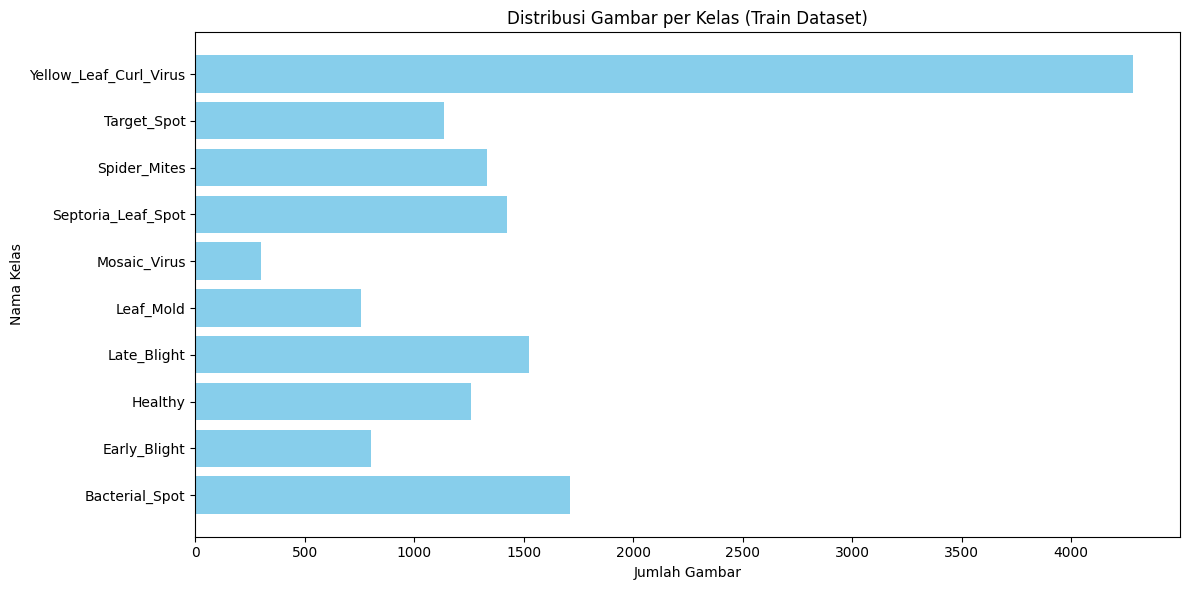

In [12]:
import matplotlib.pyplot as plt

# Hitung jumlah gambar per kelas
class_counts = {name: 0 for name in class_names}

for images, labels in train_ds.unbatch():
    label_name = class_names[int(labels)]
    class_counts[label_name] += 1

# Visualisasi
plt.figure(figsize=(12, 6))
plt.barh(list(class_counts.keys()), list(class_counts.values()), color="skyblue")
plt.title("Distribusi Gambar per Kelas (Train Dataset)")
plt.xlabel("Jumlah Gambar")
plt.ylabel("Nama Kelas")
plt.tight_layout()
plt.show()

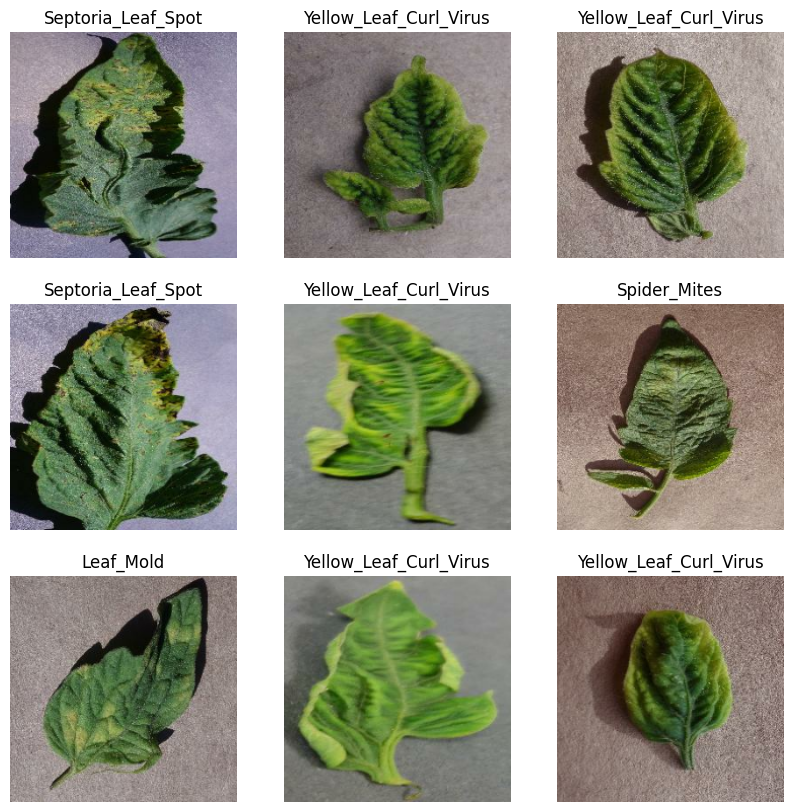

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Modeling

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Data Augmentation

In [15]:
from keras import layers

data_augmentation = keras.Sequential(
    [
        layers.Input(shape=(img_height, img_width, 3)),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.15),
        layers.RandomTranslation(0.1, 0.1),
        layers.RandomContrast(0.1),
    ]
)

### Load Base Model

In [16]:
from keras import applications

base_model = applications.EfficientNetB0(
    include_top=False, input_shape=(img_height, img_width, 3)
)

base_model.trainable = False
base_model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

Add input layer and head (output) layer

In [17]:
from keras import models

num_classes = len(class_names)

model = models.Sequential(
    [
        layers.Input(shape=(img_height, img_width, 3)),
        data_augmentation,
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

### Train Head Layers

In [ ]:
from keras import optimizers, losses, callbacks, metrics

base_learning_rate = 0.0001
model.compile(
    optimizer=optimizers.Adam(),
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[
        callbacks.EarlyStopping(patience=5, verbose=1, restore_best_weights=True)
    ],
)

Epoch 1/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 58s 106ms/step - accuracy: 0.6155 - loss: 1.2488 - val_accuracy: 0.8282 - val_loss: 0.5883
Epoch 2/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 44s 97ms/step - accuracy: 0.8404 - loss: 0.5368 - val_accuracy: 0.8571 - val_loss: 0.4639
Epoch 3/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 81s 96ms/step - accuracy: 0.8720 - loss: 0.4294 - val_accuracy: 0.8844 - val_loss: 0.3749
Epoch 4/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 46s 102ms/step - accuracy: 0.8757 - loss: 0.3931 - val_accuracy: 0.8841 - val_loss: 0.3553
Epoch 5/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 44s 96ms/step - accuracy: 0.8929 - loss: 0.3494 - val_accuracy: 0.8956 - val_loss: 0.3245
Epoch 6/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 44s 96ms/step - accuracy: 0.8893 - loss: 0.3408 - val_accuracy: 0.8813 - val_loss: 0.3462
Epoch 7/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 44s 97ms/step - accuracy: 0.8943 - loss: 0.3305 - val_accuracy: 0.9072 - val_loss: 0.2885
Epoch 8/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 82s 97ms/step - accuracy: 0.9023 - loss: 0.3071 

### Fine-Tuning

In [20]:
base_model.trainable = True

Traning time's

In [ ]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[
        callbacks.EarlyStopping(patience=5, verbose=1, restore_best_weights=True),
        callbacks.ModelCheckpoint(
            "models/efficientnetb0/efficientnetb0_best.keras",
            verbose=1,
            save_best_only=True,
        ),
    ],
)

Epoch 1/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.5817 - loss: 1.4990
Epoch 1: val_loss improved from inf to 0.77332, saving model to models/mobilenetv2/mobilenetv2_best.keras
454/454 ━━━━━━━━━━━━━━━━━━━━ 204s 366ms/step - accuracy: 0.5818 - loss: 1.4981 - val_accuracy: 0.7522 - val_loss: 0.7733
Epoch 2/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.8021 - loss: 0.6073
Epoch 2: val_loss improved from 0.77332 to 0.61989, saving model to models/mobilenetv2/mobilenetv2_best.keras
454/454 ━━━━━━━━━━━━━━━━━━━━ 164s 360ms/step - accuracy: 0.8022 - loss: 0.6072 - val_accuracy: 0.7935 - val_loss: 0.6199
Epoch 3/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.8599 - loss: 0.4233
Epoch 3: val_loss improved from 0.61989 to 0.49036, saving model to models/mobilenetv2/mobilenetv2_best.keras
454/454 ━━━━━━━━━━━━━━━━━━━━ 164s 362ms/step - accuracy: 0.8599 - loss: 0.4233 - val_accuracy: 0.8329 - val_loss: 0.4904
Epoch 4/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 0s 341m

## Evaluation

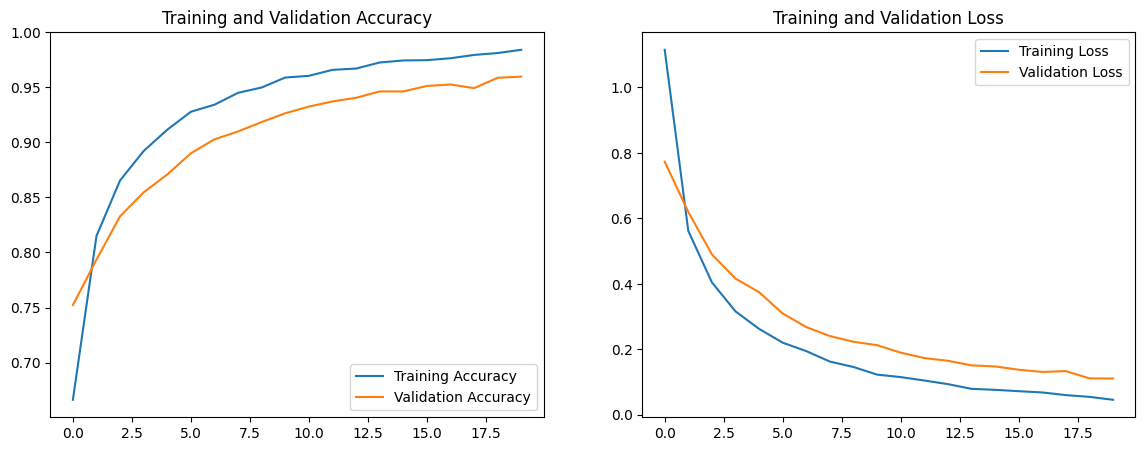

In [23]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_fine.history["accuracy"], label="Training Accuracy")
plt.plot(history_fine.history["val_accuracy"], label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")
plt.subplot(1, 2, 2)
plt.plot(history_fine.history["loss"], label="Training Loss")
plt.plot(history_fine.history["val_loss"], label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [24]:
val_loss, val_accuracy = model.evaluate(val_ds)
print("Validation loss :", val_loss)
print("Validation accuracy :", val_accuracy)

114/114 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.9636 - loss: 0.1095
Validation loss : 0.1111154854297638
Validation accuracy : 0.9598017334938049


In [ ]:
import pandas as pd

MODEL_DIR = "models/efficientnetb0/"

y_true = np.concatenate([label.numpy() for _, label in val_ds], axis=0)
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

results_df = pd.DataFrame({"y_true": y_true, "y_pred": y_pred})
results_df.to_csv(os.path.join(MODEL_DIR, "predictions.csv"), index=False)

114/114 ━━━━━━━━━━━━━━━━━━━━ 12s 88ms/step


In [ ]:
import json
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

metrics = {
    "f1": f1_score(y_true, y_pred, average="macro"),
    "accuracy": accuracy_score(y_true, y_pred),
    "precision": precision_score(y_true, y_pred, average="macro"),
    "recall": recall_score(y_true, y_pred, average="macro"),
}

metrics_path = os.path.join(MODEL_DIR, "metrics.json")
with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=4)

print(metrics)

{'f1': 0.9451182291584944, 'accuracy': 0.9598017621145375, 'precision': 0.9577367874659284, 'recall': 0.9366470148034984}


In [27]:
from sklearn.metrics import classification_report

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:

                        precision    recall  f1-score   support

        Bacterial_Spot       0.98      0.97      0.97       417
          Early_Blight       0.98      0.83      0.90       197
               Healthy       0.97      1.00      0.99       331
           Late_Blight       0.95      1.00      0.97       387
             Leaf_Mold       0.98      0.96      0.97       195
          Mosaic_Virus       1.00      0.86      0.93        72
    Septoria_Leaf_Spot       0.85      0.99      0.92       346
          Spider_Mites       0.99      0.89      0.94       343
           Target_Spot       0.87      0.87      0.87       270
Yellow_Leaf_Curl_Virus       1.00      1.00      1.00      1074

              accuracy                           0.96      3632
             macro avg       0.96      0.94      0.95      3632
          weighted avg       0.96      0.96      0.96      3632



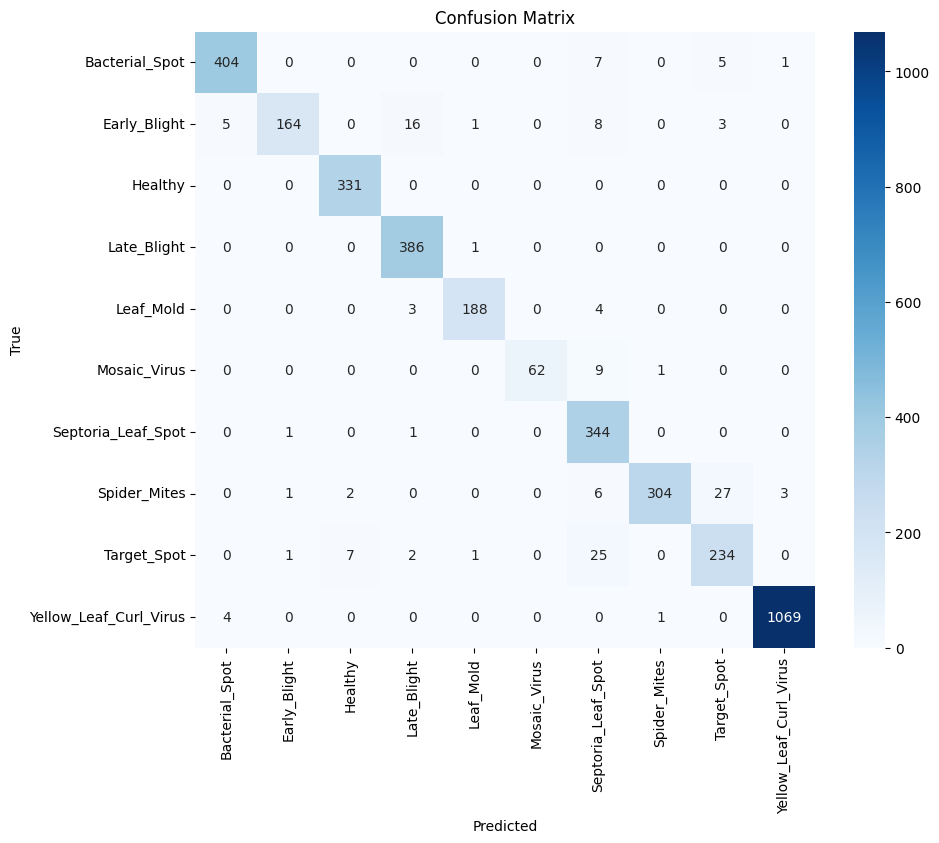

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
cm_df.to_csv(os.path.join(MODEL_DIR, "confusion_matrix.csv"))

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [29]:
df = pd.DataFrame(
    {
        "acc": history.history["accuracy"],
        "val_acc": history.history["val_accuracy"],
        "loss": history.history["loss"],
        "val_loss": history.history["val_accuracy"],
    }
)
df.to_csv(os.path.join(MODEL_DIR, "history.csv"), index=False)

In [30]:
model.save(os.path.join(MODEL_DIR, "cnn_final.keras"))